List of packages, split into groups of analysis.

In [1]:
# Graphing
import requests
import networkx as nx
import matplotlib.pyplot as plt
import csv
from math import pi, sqrt
from tabulate import tabulate
import numpy as np
import powerlaw

# Co Occurences
import json
from datetime import datetime
from collections import defaultdict
import seaborn as sns
from matplotlib.patches import Patch
from tabulate import tabulate

# Sentimental Analysis
import nltk
import pandas as pd
import numpy as np
import requests
import networkx as nx
import re
import matplotlib.pyplot as plt
import os
import pickle
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Graphing of the social network of Game of Thrones

The Following section contains all functions for the graphing of Game of Thrones social network. These functions define how we scrape the API of wikipedia, and find in degree and out degree of a graph.

In [2]:
# Functions section

# Function to fetch links from a character's Game of Thrones Fandom Wiki page
def get_character_links(character_name):
    base_url = "https://gameofthrones.fandom.com/api.php"
    params = {
        "action": "parse",
        "page": character_name,
        "prop": "links",
        "format": "json",
    }

    response = requests.get(base_url, params=params)
    data = response.json()

    links = []

    if "parse" in data and "links" in data["parse"]:
        links = [link["*"] for link in data["parse"]["links"] if link["*"] in character_names]

    return links

# Function to find indegree and outdegree of a network
def in_out_degrees(G):
    nodes = [node for node in G.nodes()]
    in_degrees = dict(G.in_degree(nodes))
    out_degrees = dict(G.out_degree(nodes))

    in_degrees = sorted(in_degrees.items(), key=lambda x: x[1], reverse=True)[:5]
    out_degrees = sorted(out_degrees.items(), key=lambda x: x[1], reverse=True)[:5]

    return in_degrees, out_degrees

Using a CSV file containing all character names, we then crrate a graph of the social network of Game of Thrones. The nodes are characters, and the edges are whether their wikipedia pages link to each other.

In [3]:
# Load the CSV file with the Game of Thrones characters' names
character_names = []

with open("../data/raw/characters_v4.csv", "r") as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        character_names.append(row[0])

# Create a directed NetworkX graph
G = nx.DiGraph()

for character_name in character_names:
    G.add_node(character_name)

# Populate the graph with directed edges between characters
for character_name in character_names:
    character_links = get_character_links(character_name)
    for link in character_links:
        G.add_edge(character_name, link)

In [4]:
# Save the graph in a GraphML file
nx.write_graphml(G, "got_network.graphml")

In [5]:
# If you have already saved the graph, you can load it from the file
G = nx.read_graphml("got_network.graphml")

This is the main graph displayed in the notebook. We build this using the networkx package, and then use matplotlib to display the graph. The positioning is determined by the kamada_kawai_layout function in networkx. The size of a node is determined by the in degree of the node, and we color the top 10 characters with the highest in degree red.

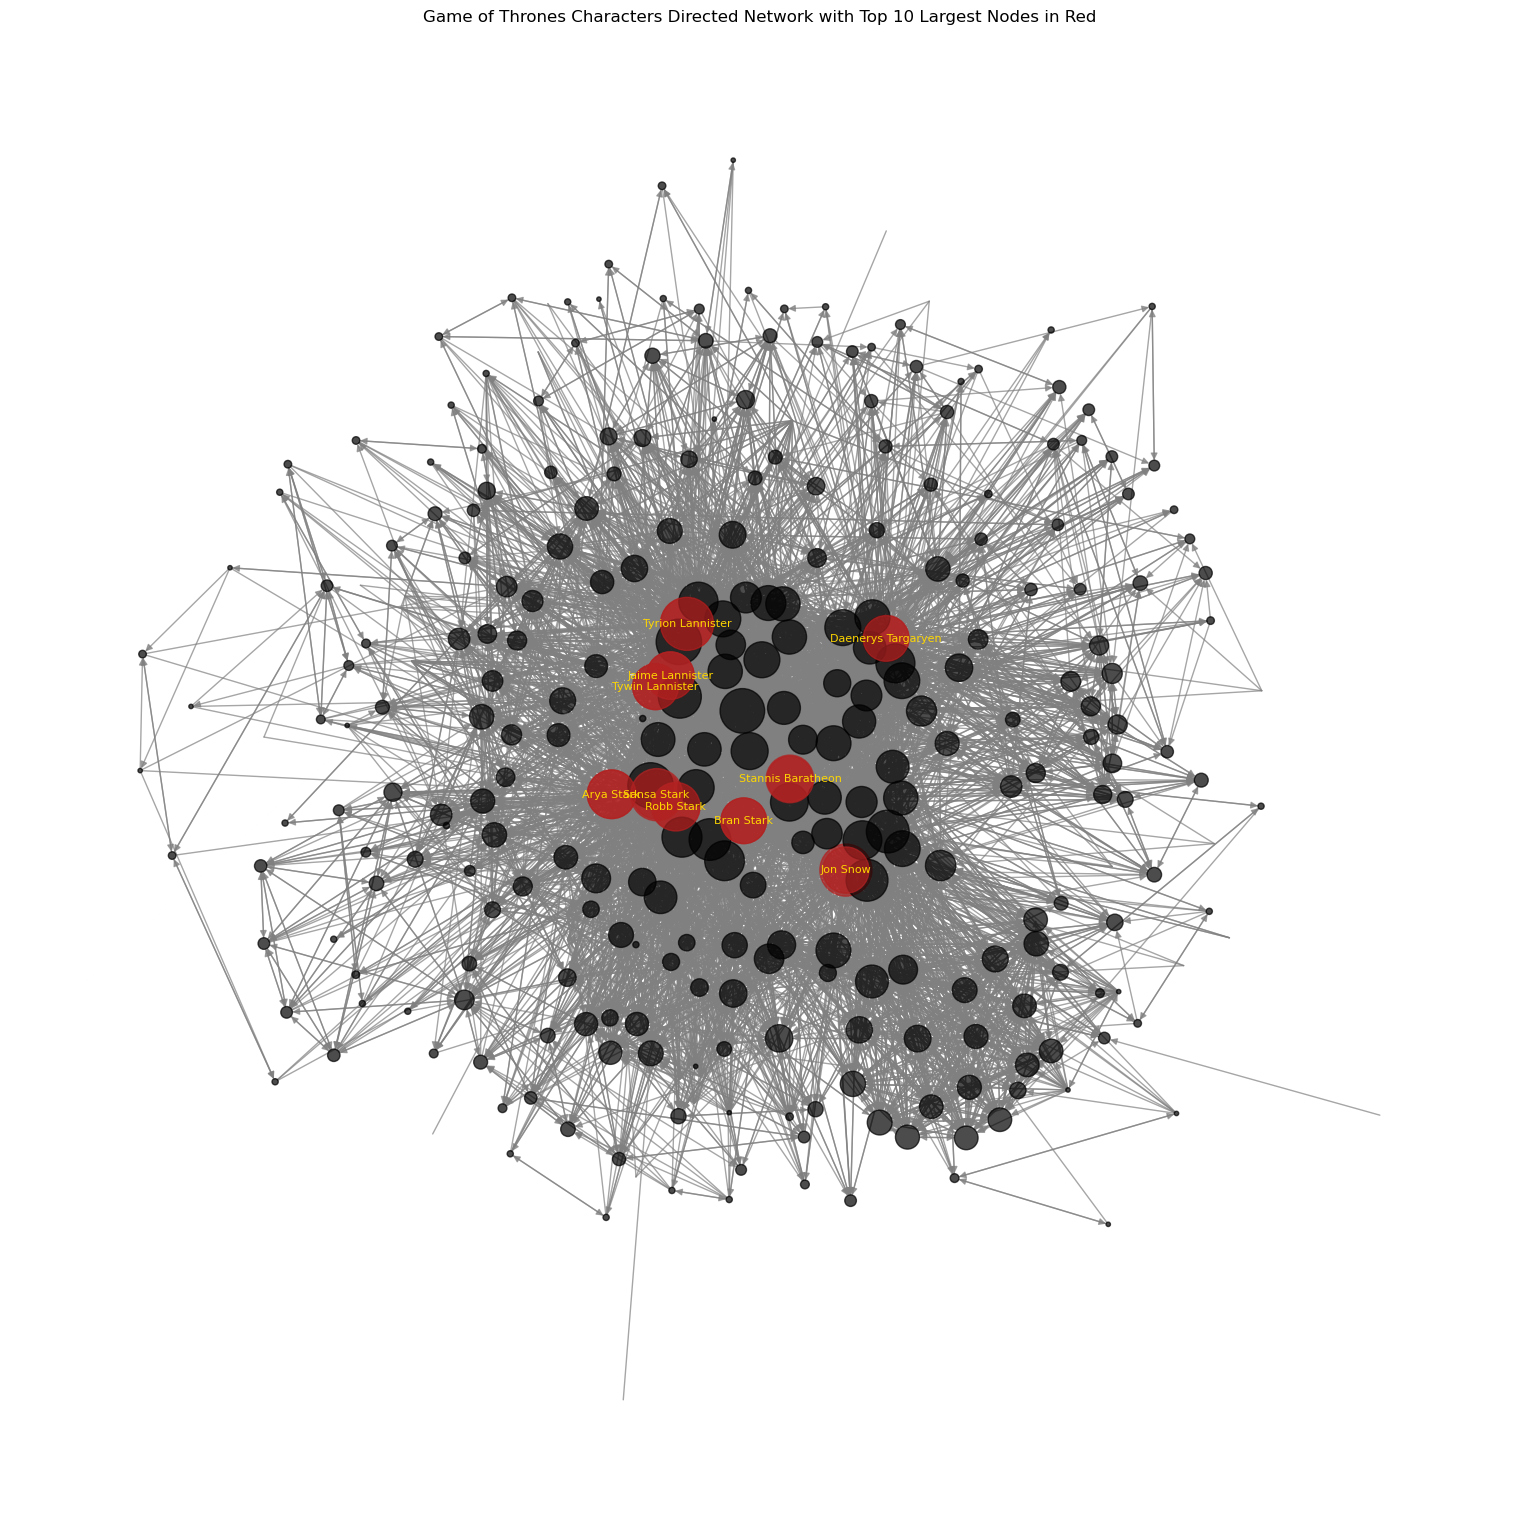

In [6]:
# Calculate in-degrees
in_degrees = G.in_degree()

# Determine the 10 nodes with the highest in-degrees
top_10_nodes = sorted(in_degrees, key=lambda x: x[1], reverse=True)[:10]

# Create a list of labels for the 10 biggest nodes
node_labels = {}
for node, in_degree in top_10_nodes:
    node_labels[node] = node

# Calculate node sizes based on in-degrees
node_sizes = [in_degree * 10 for _, in_degree in in_degrees]

# Use the Kamada-Kawai layout algorithm for node positioning
pos = nx.kamada_kawai_layout(G)

# Increase the figure size for better visualization
plt.figure(figsize=(15, 15))

# Specify a different color for the 10 largest nodes
node_colors = ["firebrick" if node in [node for node, _ in top_10_nodes] else "black" for node in G.nodes()]

# Remove self loops
G.remove_edges_from(nx.selfloop_edges(G))

# Draw nodes with sizes and labels for all nodes except the top 10
nx.draw(G, 
        pos=pos, 
        with_labels=False, 
        node_size=node_sizes, 
        node_color=node_colors, 
        edge_color="grey", 
        font_size=10, 
        alpha=0.7,
        arrows=True
    )

# Draw labels for the 10 largest nodes
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8, font_color='gold')

# Extract information for the top 10 nodes
top_10_node_list = [node for node, _ in top_10_nodes]
top_node_sizes = [size for node, size in zip(G.nodes(), node_sizes) if node in top_10_node_list]

# Draw the top 10 nodes again to ensure they're on top
nx.draw_networkx_nodes(G, 
                       pos, 
                       nodelist=top_10_node_list, 
                       node_size=top_node_sizes, 
                       node_color="firebrick", 
                       alpha=0.7
                      )

plt.title("Game of Thrones Characters Directed Network with Top 10 Largest Nodes in Red")
plt.show()

In this section we find the characters with most in- and out degree, and print them. We also plot the graph degree distributions, together with the log log plots of the same distributions.

Top 5 most connected nodes (characters):

 In Degree                        | Out Degree
----------------------------------+-----------------------------------
 Character        |   In Degree   | Character        |   Out Degree
 ------------------+------------- | ------------------+--------------
 Tyrion Lannister |         145   | Jon Snow         |          125
 Jon Snow         |         140   | Sansa Stark      |           97
 Sansa Stark      |         122   | Tyrion Lannister |           91
 Arya Stark       |         121   | Jaime Lannister  |           91
 Robb Stark       |         117   | Robb Stark       |           90


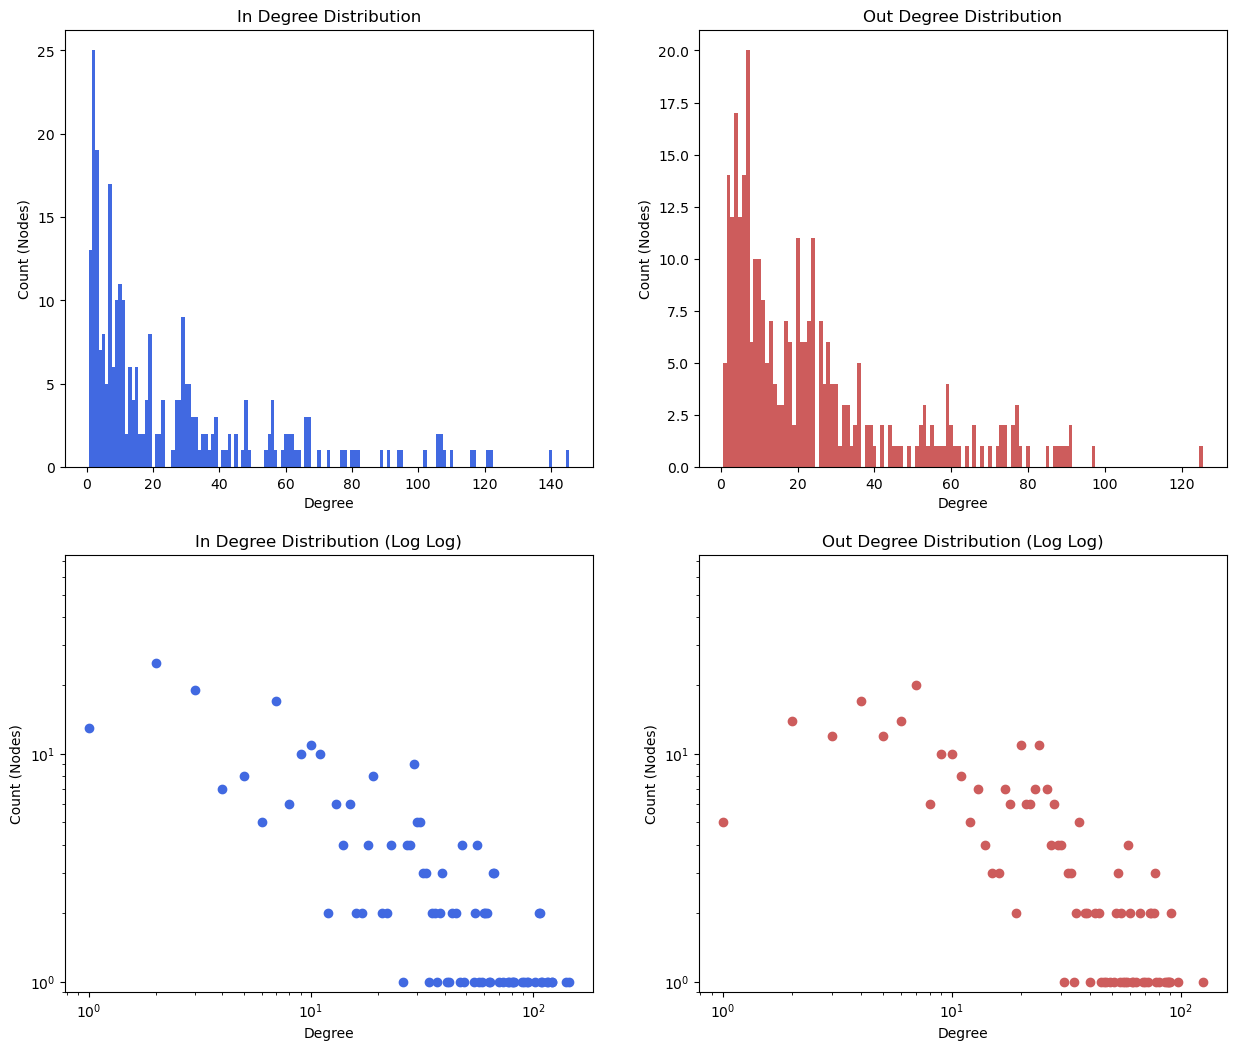

In [7]:
print('Top 5 most connected nodes (characters):\n')
in_degrees, out_degrees = in_out_degrees(G)
in_table = tabulate(in_degrees, headers=['Character', 'In Degree'], tablefmt="presto")
out_table = tabulate(out_degrees, headers=['Character', 'Out Degree'], tablefmt="presto")

table = tabulate([list(item) for item in zip(str(in_table).splitlines(), str(out_table).splitlines())],
                        ["In Degree", "Out Degree"], tablefmt="presto")

print(table)

# In degree distribution
in_degrees = dict(G.in_degree())
in_values = sorted(set(in_degrees.values()))
in_hist = [list(in_degrees.values()).count(x) for x in in_values]

# Out degree distribution
out_degrees = dict(G.out_degree())
out_values = sorted(set(out_degrees.values()))
out_hist = [list(out_degrees.values()).count(x) for x in out_values]

# Bins
bins = np.linspace(0, 30, 100)

plt.figure(figsize=(15, 12.5))
plt.subplot(2, 2, 1)
#plt.hist(in_hist, bins=bins, color='indianred')
plt.bar(in_values[1:len(in_values)], in_hist[1:len(in_hist)], width=1, color='royalblue')
plt.title("In Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Count (Nodes)")

plt.subplot(2, 2, 2)
#plt.hist(out_hist, bins=bins, color='indianred')
plt.bar(out_values[1:len(out_values)], out_hist[1:len(out_hist)], width=1, color='indianred')
plt.title("Out Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Count (Nodes)")

# Log Log plot
plt.subplot(2, 2, 3)
plt.loglog(in_values, in_hist, 'o', color='royalblue')
plt.title("In Degree Distribution (Log Log)")
plt.xlabel("Degree")
plt.ylabel("Count (Nodes)")
plt.ylim(0.9, 75)

plt.subplot(2, 2, 4)
plt.loglog(out_values, out_hist, 'o', color='indianred')
plt.title("Out Degree Distribution (Log Log)")
plt.xlabel("Degree")
plt.ylabel("Count (Nodes)")
plt.ylim(0.9, 75)

plt.show()


In this section we calculate the powerlaw exponent of the in- and out degree distributions. We use the powerlaw package to do this.

In [8]:
# Power law fit
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())

in_degrees = [in_degree for _, in_degree in in_degrees.items()]
out_degrees = [out_degree for _, out_degree in out_degrees.items()]

in_fit = powerlaw.Fit(in_degrees)
out_fit = powerlaw.Fit(out_degrees)

print("In Degree Power Law Fit")
print("alpha in = ", in_fit.power_law.alpha)
print("alpha out = ", out_fit.power_law.alpha)

In Degree Power Law Fit
alpha in =  3.744274775510896
alpha out =  2.4640203759503483


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/niklas/anaconda3/envs/socialgraphs/lib/python3.10/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


# Co-Occurrences within Game of Thrones

The functions for the co-occurrence analysis of Game of Thrones are defined here. See code comments for more details.

In [9]:
character_colors = defaultdict(lambda: "#DBA374")


def datetime_to_seconds(t):
    time = datetime.strptime(t, "%H:%M:%S").time()
    return time.hour * 3600 + time.minute * 60 + time.second


def top_n_characters(matrix, characters, n=50):
    "Find top n characters by total time"
    summed_times = [(idx, sum(row)) for (idx, row) in enumerate(matrix)]
    summed_times = sorted(summed_times, key=lambda x: x[1], reverse=True)
    top_n = summed_times[:n]
    # Convert indices to character names
    top_n = [(characters[idx], time) for (idx, time) in top_n]
    return top_n


def is_symmetrical(matrix):
    "Check if matrix is symmetrical"
    for i in range(len(matrix)):
        for j in range(len(matrix)):
            if matrix[i][j] != matrix[j][i]:
                return False
    return True


def matrix_eye(matrix):
    "Check if matrix has a 1 on the diagonal"
    eye = [matrix[i][i] for i in range(len(matrix))]
    return any(eye)


def make_graph(matrix_full, characters):
    "Create graph from given matrix and array of character names"
    matrix_norm = normalize_matrix(matrix_full)
    G = nx.Graph()
    for idx, row in enumerate(matrix_full):
        total_time = sum(row)
        G.add_node(characters[idx], total_time=total_time)

    for i in range(len(characters)):
        for j in range(len(characters)):
            if i != j:
                interaction_time = matrix_norm[i][j]
                if interaction_time == 0.0:
                    continue
                G.add_edge(
                    characters[i], characters[j], interaction_time=interaction_time
                )
    return G


def make_digraph(matrix_full, characters):
    "Create directed graph from given matrix and array of character names"
    matrix_norm = normalize_matrix(matrix_full)
    DG = nx.DiGraph()
    for idx, row in enumerate(matrix_full):
        total_time = sum(row)
        DG.add_node(characters[idx], total_time=total_time)

    for i in range(len(characters)):
        for j in range(len(characters)):
            if i != j:
                interaction_time = matrix_norm[i][j]
                if interaction_time == 0.0:
                    continue
                DG.add_edge(
                    characters[i], characters[j], interaction_time=interaction_time
                )
    return DG


def area_to_radius(area):
    return (area / pi) ** 0.5


def color_nodes(G):
    "Color nodes by their house. Default color if no house exists."
    colors = []
    for node in G.nodes():
        colors.append(character_colors[node])
    return colors


def draw_graph(G):
    node_sizes = nx.get_node_attributes(G, "total_time").values()
    node_sizes = [v * 0.01 for v in node_sizes]
    edges = G.edges()
    widths = [G[u][v]["interaction_time"] * 35 for u, v in edges]
    k = 1 / sqrt(len(G.nodes())) * 4
    nx.draw(
        G,
        pos=nx.spring_layout(G, k=k),
        with_labels=True,
        edge_color="grey",
        node_size=node_sizes,
        node_color=color_nodes(G),
        alpha=0.7,
        font_color="black",
        width=widths,
    )


def draw_digraph(G):
    node_sizes = nx.get_node_attributes(G, "total_time").values()
    node_sizes = [area_to_radius(v) * 10 for v in node_sizes]
    edge_widths = [G[u][v]["interaction_time"] * 8 for u, v in G.edges()]
    k = 1 / sqrt(len(G.nodes())) * 5
    nx.draw(
        G,
        pos=nx.spring_layout(G, k=k),
        with_labels=True,
        edge_color="grey",
        node_size=node_sizes,
        node_color=color_nodes(G),
        alpha=0.7,
        font_color="black",
        width=edge_widths,
    )


def episodes_from_season(data, season):
    "Find episodes from a season"
    return [episode for episode in data if episode["seasonNum"] == season]


def make_matrix(episodes, characters):
    "Create a matrix with characters x characters dimension"
    matrix = []
    for i in range(len(characters)):
        matrix.append([0] * len(characters))

    for episode in episodes:
        for scene in episode["scenes"]:
            sceneLength = scene["sceneLength"]
            characters_in_scene = [
                character["name"] for character in scene["characters"]
            ]

            # Fill the matrix
            for i in range(len(characters_in_scene)):
                for j in range(len(characters_in_scene)):
                    # Skip diagonal, can be recomputed as sum(row)
                    if i != j:
                        matrix[characters.index(characters_in_scene[i])][
                            characters.index(characters_in_scene[j])
                        ] += sceneLength  # Add scene length to matrix

    return matrix


def normalize_matrix(matrix):
    "Matrix row normalization"
    normalized_matrix = []
    for row in matrix:
        total = sum(row)
        if total == 0:
            normalized_matrix.append(row)
            continue
        normalized_row = [val / total for val in row]
        normalized_matrix.append(normalized_row)
    return normalized_matrix


def top_characters_per_season(G, n=10):
    "Find top n characters per season with their degree"
    node_degrees = [(node, degree) for node, degree in G.degree()]
    sorted_nodes = sorted(node_degrees, key=lambda x: x[1], reverse=True)

    return sorted_nodes[:n]


def pp(season, top_characters):
    "Pretty print the top characters as sa table"
    table = tabulate(top_characters, headers=["Character", "Degree"], tablefmt="presto")
    print(f"Most influential characters in season {season}:\n\n{table}\n\n")

Below we load the JSON files containing episode, character and colors data. We use these files to find if a character is in a season. Thereafter we prepare some colors for the graphing of the co-occurrence network.

In [10]:
from collections import defaultdict

episodes_data = json.load(open("../data/raw/episodes.json", "r"))
characters_data = json.load(open("../data/raw/characters.json", "r"))
colors = json.load(open("../data/raw/colors.json", "r"))
# We only need colors by houses
colors = colors["houses"]

episodes = episodes_data["episodes"]
print("Number of episodes:", len(episodes))

characters = set()
characters_by_season = {}

for c in characters:
    character_colors[c]

for episode in episodes:
    season = episode["seasonNum"]
    scenes = episode["scenes"]
    for scene in scenes:
        scene_length = datetime_to_seconds(scene["sceneEnd"]) - datetime_to_seconds(
            scene["sceneStart"]
        )
        scene["sceneLength"] = scene_length
        for character in scene["characters"]:
            name = character["name"]
            characters.add(name)
            if season not in characters_by_season:
                characters_by_season[season] = set()
            characters_by_season[season].add(name)

# Sort characters characters_by_season
characters = sorted(list(characters))
for season in characters_by_season:
    characters_by_season[season] = sorted(list(characters_by_season[season]))

# Create a dict of character name to color
character_colors = defaultdict(lambda: "#ceccd7")
for character in characters_data["characters"]:
    name = character["characterName"]

    if name not in characters:
        continue

    if "houseName" in character:
        house = (
            character["houseName"][0]
            if isinstance(character["houseName"], list)
            else character["houseName"]
        )

        if house in colors:
            character_colors[name] = colors[house]
        else:
            print("WARNING missing color for house:", house)

for c in characters:
    character_colors[c]

Number of episodes: 73
WARNING missing color for house: Arryn
WARNING missing color for house: Umber
WARNING missing color for house: Tarly


Below we construct the matrix for each season. Doing this we now have a matrix for each season, where character data is stored and interactions with other characters is also stored.

In [11]:
season_1_matrix = make_matrix(episodes_from_season(episodes, 1), characters_by_season[1])
season_2_matrix = make_matrix(episodes_from_season(episodes, 2), characters_by_season[2])
season_3_matrix = make_matrix(episodes_from_season(episodes, 3), characters_by_season[3])
season_4_matrix = make_matrix(episodes_from_season(episodes, 4), characters_by_season[4])
season_5_matrix = make_matrix(episodes_from_season(episodes, 5), characters_by_season[5])
season_6_matrix = make_matrix(episodes_from_season(episodes, 6), characters_by_season[6])
season_7_matrix = make_matrix(episodes_from_season(episodes, 7), characters_by_season[7])
season_8_matrix = make_matrix(episodes_from_season(episodes, 8), characters_by_season[8])

complete_matrix = make_matrix(episodes, characters)

In [12]:
# Chechking the total runtime
total_time = sum(scene['sceneLength'] for episode in episodes for scene in episode['scenes'])

hours, remainder = divmod(total_time, 3600)
minutes, seconds = divmod(remainder, 60)

print(f'Total time: {hours} hours, {minutes} minutes, {seconds} seconds')


Total time: 65 hours, 57 minutes, 3 seconds


We define the top 50 characters across all the seasons

In [13]:
top_50_full = top_n_characters(complete_matrix, characters)

Below we make all the graphs for each season. We use the networkx package to do this. We then use matplotlib to display the graphs. We also define the total graph, where all characters across all seasons, with edges being interactions across the entirety. We visualize the entire graph with only the top 50 characters who has scene time.

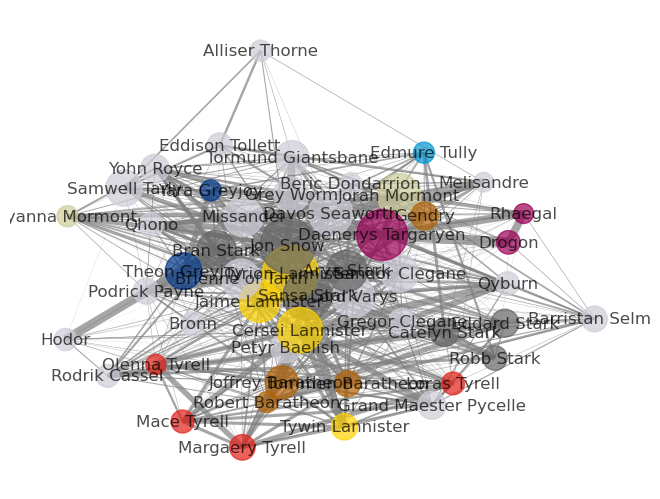

In [14]:
G_S1 = make_graph(season_1_matrix, characters_by_season[1])
G_S2 = make_graph(season_2_matrix, characters_by_season[2])
G_S3 = make_graph(season_3_matrix, characters_by_season[3])
G_S4 = make_graph(season_4_matrix, characters_by_season[4])
G_S5 = make_graph(season_5_matrix, characters_by_season[5])
G_S6 = make_graph(season_6_matrix, characters_by_season[6])
G_S7 = make_graph(season_7_matrix, characters_by_season[7])
G_S8 = make_graph(season_8_matrix, characters_by_season[8])

# Complete graph
G_complete = make_graph(complete_matrix, characters)
# Limit to top 50 notes
nodes = G_complete.nodes(data=True)
nodes = sorted(nodes, key=lambda x: x[1]["total_time"], reverse=True)[:50]
G_complete_top = G_complete.subgraph([node[0] for node in nodes])
draw_graph(G_complete_top)

Below we draw the entire co occurence graph, we base the node sizes on the total scene time, and add edge weight based on amount of interactions between nodes. This graph is a directed graph as to show who interacts with who, and whether the character interacts back. This graph is not included in the main report.

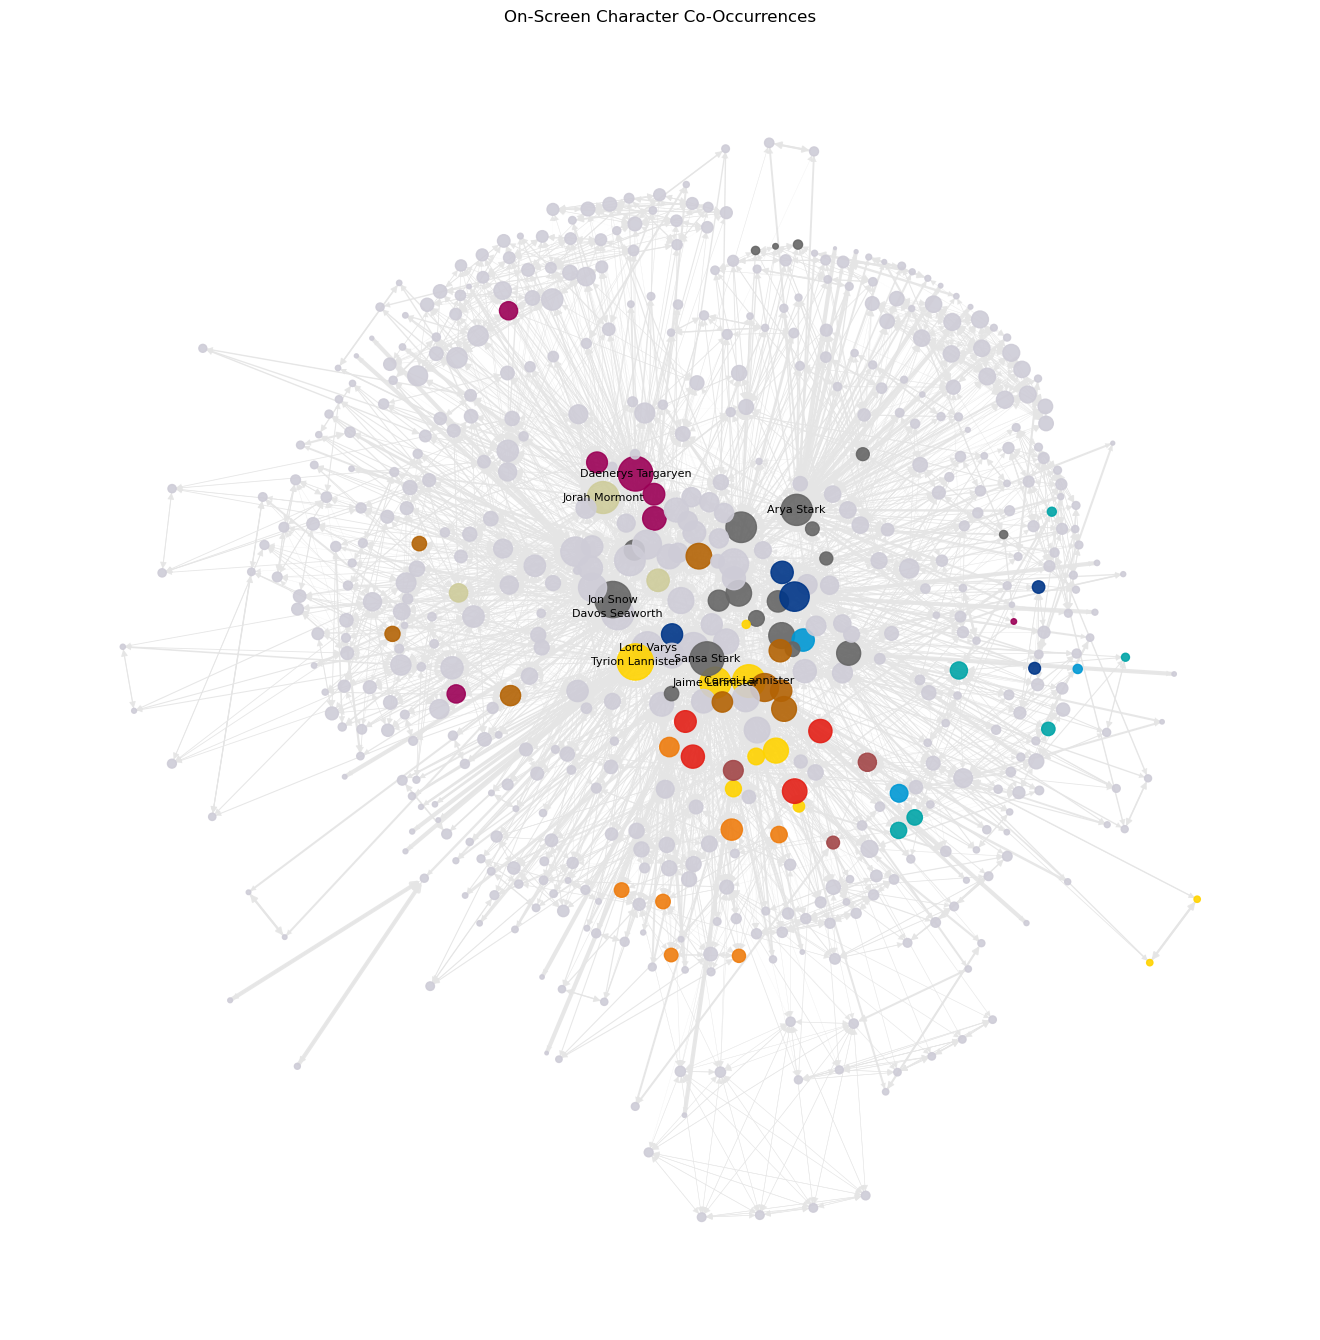

In [15]:
DG_complete = make_digraph(complete_matrix, characters)

top_nodes = sorted(
    G_complete.nodes(data=True), key=lambda x: x[1]["total_time"], reverse=True
)[:10]
top_labels = {node: node for node, _ in top_nodes}

# Parameters
node_scaling = 3
edge_width_scaling = 3
edge_weight_scaling = 0.5

# Node size based on 'total time'
node_sizes = [
    area_to_radius(v) * node_scaling
    for v in nx.get_node_attributes(DG_complete, "total_time").values()
]

# Edge width based on 'interaction time'
edge_widths = [
    DG_complete[u][v]["interaction_time"] * edge_width_scaling
    for u, v in DG_complete.edges()
]

pos = nx.kamada_kawai_layout(DG_complete)

plt.figure(figsize=(13, 13))
nx.draw(
    DG_complete,
    pos=pos,
    with_labels=False,
    edge_color="#e5e5e5",
    node_size=node_sizes,
    node_color=color_nodes(DG_complete),
    alpha=0.9,
    font_color="black",
    width=edge_widths,
)
nx.draw_networkx_labels(
    DG_complete, pos, labels=top_labels, font_size=8, font_color="black"
)
plt.title("On-Screen Character Co-Occurrences")
plt.show()

For the complete graph, we find the degree distribution, and the log log plot for the same distribution.

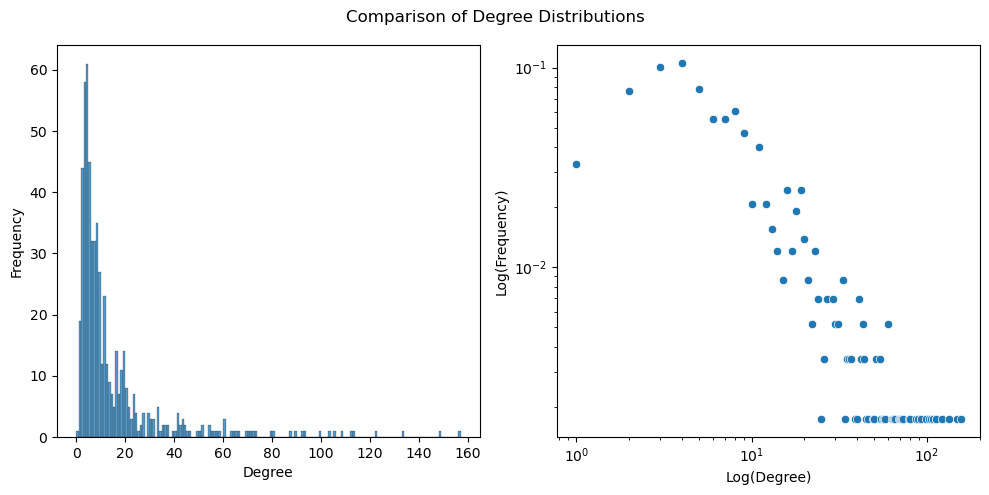

In [16]:
complete_degree_sequence = [d for _, d in G_complete.degree()]
hist, bin_edges = np.histogram(complete_degree_sequence, bins=range(min(complete_degree_sequence), max(complete_degree_sequence) + 2), density=True)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Comparison of Degree Distributions')

sns.histplot(x=complete_degree_sequence, ax=ax0, bins=range(min(complete_degree_sequence), max(complete_degree_sequence) + 2))
ax0.set_xlabel('Degree')
ax0.set_ylabel('Frequency')

sns.scatterplot(x=bin_edges[:-1], y=hist, ax=ax1, marker='o')
plt.xscale('log')
plt.yscale('log')
ax1.set_xlabel('Log(Degree)')
ax1.set_ylabel('Log(Frequency)')

fig.tight_layout()
plt.show()


For easy visual inspection of the degree distributions across all seasons, we plot a histogram with the overall distribution on top.

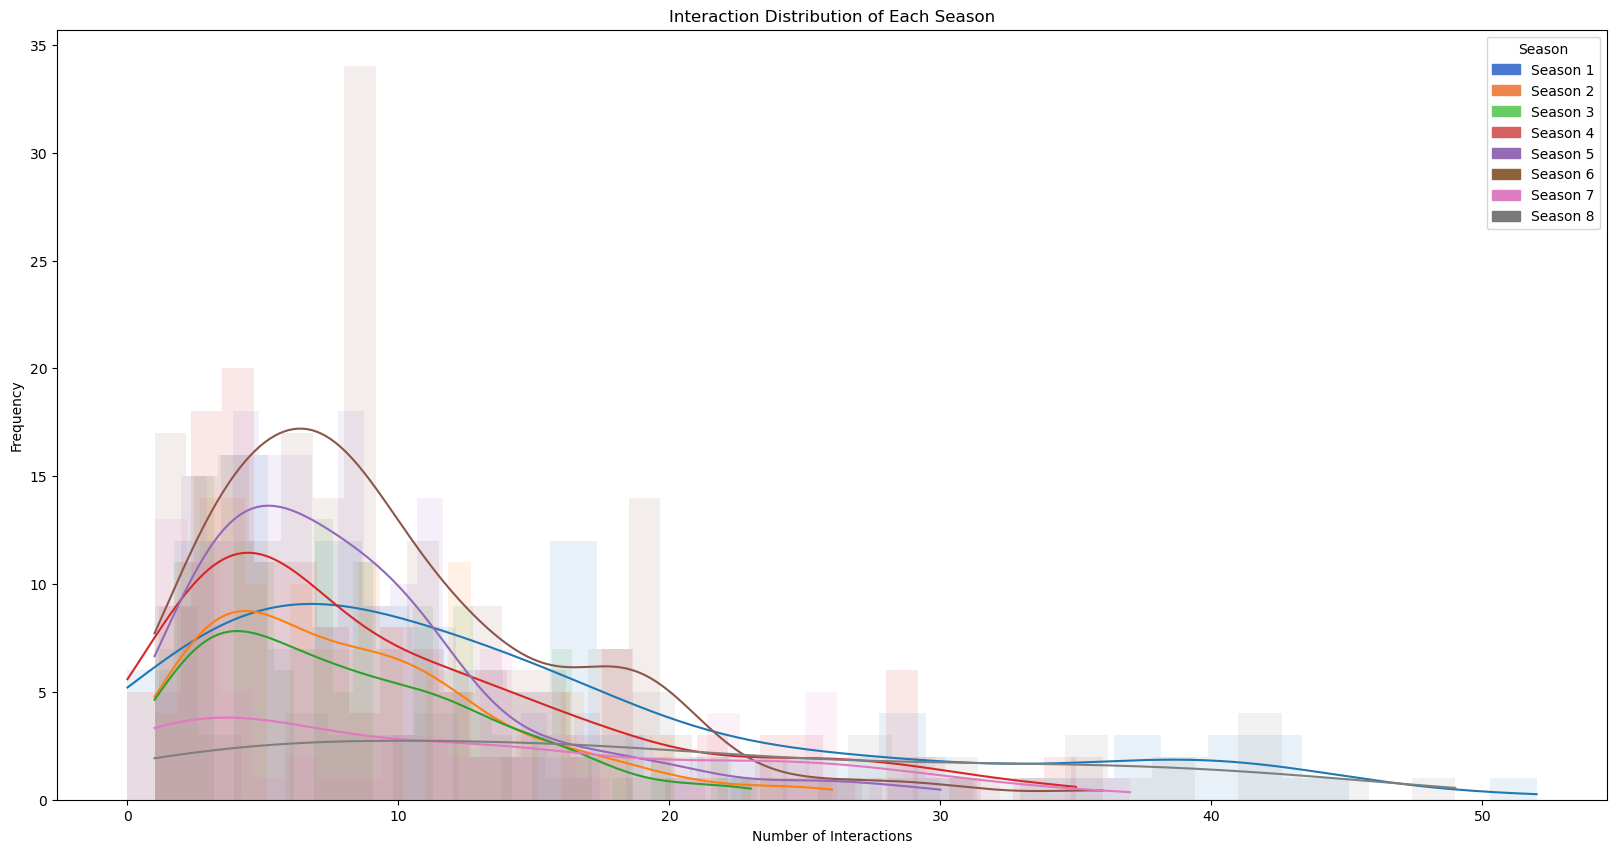

In [31]:
def generate_legend():
    # Define your rectangles and corresponding labels
    season_color_palette = sns.palettes.color_palette("muted", 8)
    rectangles = [
        Patch(color=c, label=f"Season {i+1}")
        for i, c in enumerate(season_color_palette)
    ]
    return rectangles

season_graphs = [G_S1, G_S2, G_S3, G_S4, G_S5, G_S6, G_S7, G_S8]
season_degrees = zip(
    [f"Season {i}" for i in range(1, len(season_graphs) + 1)],
    [[d for _, d in G_season.degree()] for G_season in season_graphs],
)

for season, degree_sequence in season_degrees:
    sns.histplot(
        degree_sequence,
        bins=30,
        kde=True,
        label=season,
        edgecolor=None,
        alpha=0.1,
        legend=False,
    )

plt.xlabel("Number of Interactions")
plt.ylabel("Frequency")
plt.title("Interaction Distribution of Each Season")
plt.legend(title="Season", handles=generate_legend(), loc='upper right')

plt.show()

We take the 10 characters from the social graph, and prepare data for the bump plot. The tables produced are not included in the main report.

In [35]:
# The most influential characters by highest number of interactions for every season
for i, g in enumerate(season_graphs):
    pp(i+1, top_characters_per_season(g))
    
top_characters = {c for g in season_graphs for c, _ in top_characters_per_season(g)}

chart_characters = [
    {"Name": "Tyrion Lannister", "Color": "red"},
    {"Name": "Jaime Lannister", "Color": "blue"},
    {"Name": "Tywin Lannister", "Color": "green"},
    {"Name": "Stannis Baratheon", "Color": "cyan"},
    {"Name": "Daenerys Targaryen", "Color": "magenta"},
    {"Name": "Jon Snow", "Color": "orange"},
    {"Name": "Arya Stark", "Color": "purple"},
    {"Name": "Sansa Stark", "Color": "brown"},
    {"Name": "Robb Stark", "Color": "pink"},
    {"Name": "Bran Stark", "Color": "grey"},
]

for idx, character in enumerate([c["Name"] for c in chart_characters]):
    ranks = []
    for g in season_graphs:
        rank = g.degree(character) if g.has_node(character) else None
        ranks.append(rank)

    chart_characters[idx]["Ranks"] = ranks

Most influential characters in season 1:

 Character         |   Degree
-------------------+----------
 Eddard Stark      |       52
 Arya Stark        |       44
 Tyrion Lannister  |       43
 Catelyn Stark     |       42
 Rodrik Cassel     |       42
 Joffrey Baratheon |       40
 Jon Snow          |       40
 Sansa Stark       |       40
 Sandor Clegane    |       39
 Theon Greyjoy     |       39


Most influential characters in season 2:

 Character         |   Degree
-------------------+----------
 Tyrion Lannister  |       26
 Joffrey Baratheon |       25
 Sansa Stark       |       24
 Cersei Lannister  |       23
 Arya Stark        |       20
 Bronn             |       20
 Sandor Clegane    |       20
 Petyr Baelish     |       19
 Brienne of Tarth  |       18
 Theon Greyjoy     |       18


Most influential characters in season 3:

 Character        |   Degree
------------------+----------
 Robb Stark       |       23
 Samwell Tarly    |       22
 Tyrion Lannister |       22
 S

Plotting of the bump chart.

In [38]:
# Fix scores for characters who died or appeared in flashbacks
for c in chart_characters:
    if c["Name"] == "Tywin Lannister":
        c["Ranks"][4] = None
    if c["Name"] == "Robb Stark":
        c["Ranks"][5] = None
    if c["Name"] == "Bran Stark":
        c["Ranks"][6] += 1
        c["Ranks"][7] += 1

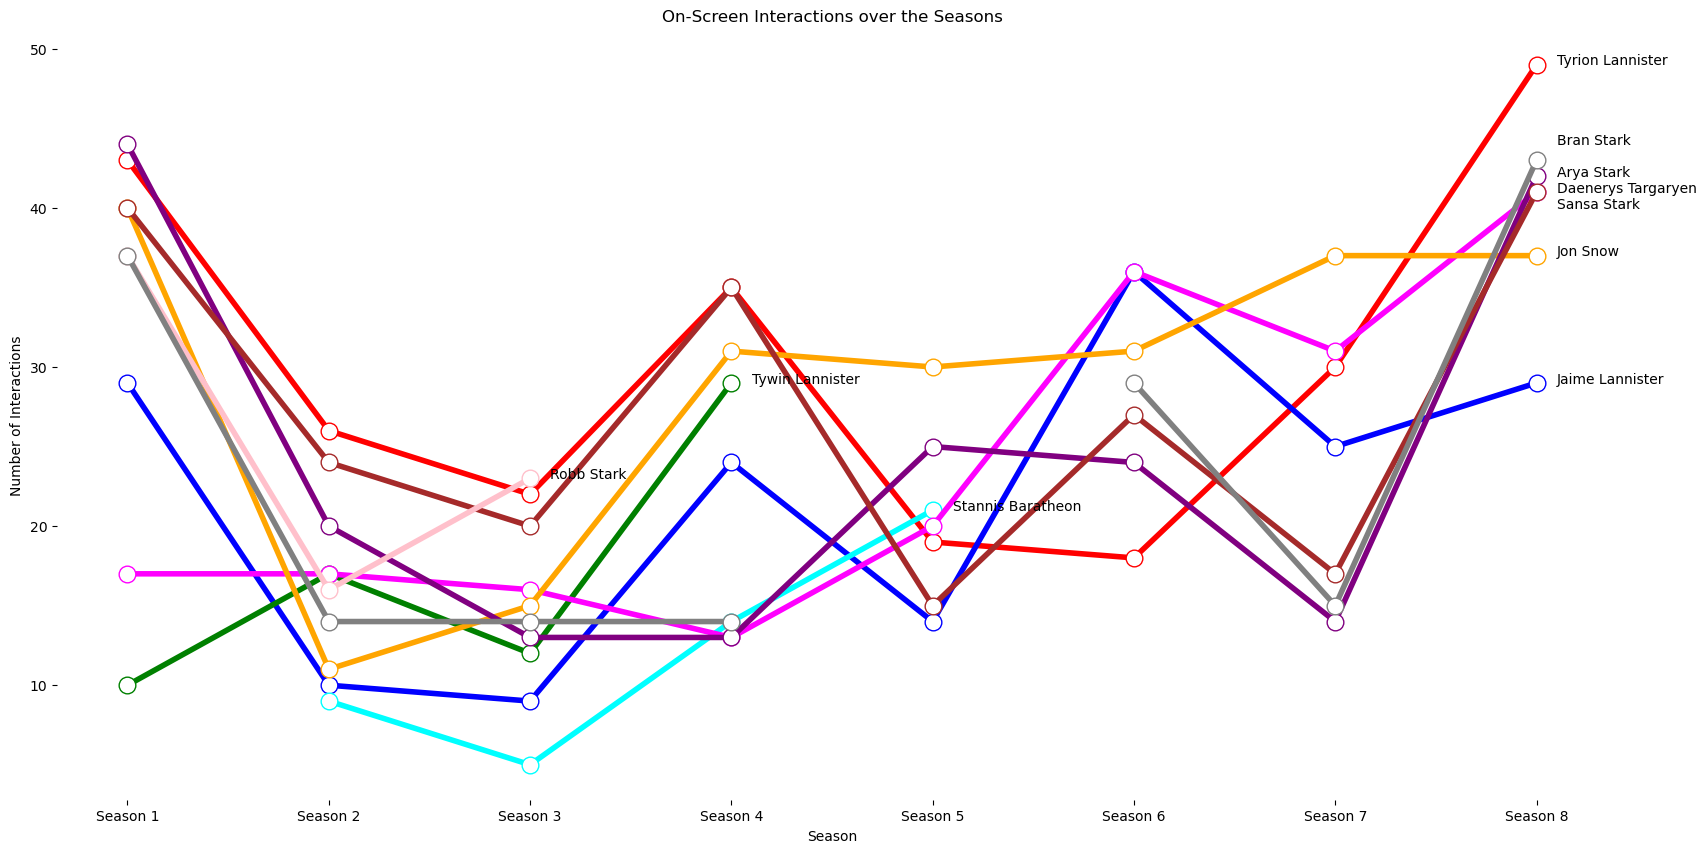

In [40]:
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (20, 10)

x_axis = [f"Season {i+1}" for i in range(len(season_graphs))]

for ele in chart_characters:
    name, ranks = ele["Name"], ele["Ranks"]
    ax.plot(
        x_axis,
        ranks,
        label=name,
        marker="o",
        markersize=12,
        markerfacecolor="white",
        color=ele["Color"],
        linewidth=4,
    )

    last_present_value = next(
        idx for idx, x in enumerate(reversed(ranks)) if x is not None
    )
    last_present_value = len(ranks) - last_present_value - 1

    xy = (last_present_value + 0.1, ranks[last_present_value])

    if name == "Daenerys Targaryen":
        xy = (last_present_value + 0.1, ranks[last_present_value] - 0)
    elif name == "Sansa Stark":
        xy = (last_present_value + 0.1, ranks[last_present_value] - 1)
    elif name == "Bran Stark":
        xy = (last_present_value + 0.1, ranks[last_present_value] + 1)

    ax.annotate(
        name,
        xy=xy,
    )

for spine in ax.spines.values():
    spine.set_visible(False)

plt.xlabel("Season")
plt.ylabel("Number of Interactions")
plt.title("On-Screen Interactions over the Seasons")
plt.show()

# Sentiment Analysis of Game of Thrones


Here we do the sentimental analysis for the individual characters in Game of Thrones, by using a pre defined sentimental word dictionary. We also use a csv containing the script for all seasons said by each character.

In [21]:
# Load Game_of_Thrones_Script.csv
df = pd.read_csv('../data/transcript/Game_of_Thrones_Script.csv', header=0, encoding='utf-8-sig')
sentiment_doc = pd.read_csv('../data/transcript/Data_Set_S1.txt', header=2, encoding='utf-8-sig', sep='\t')

print(df.head())

# Collect all the unique characters
characters = df['Name'].unique().tolist()

# Collect all unique episode titles
episodes = df['Episode Title'].unique().tolist()

# Collect all season numbers
seasons = df['Season'].unique().tolist()

  Release Date    Season    Episode     Episode Title          Name  \
0   2011-04-17  Season 1  Episode 1  Winter is Coming  waymar royce   
1   2011-04-17  Season 1  Episode 1  Winter is Coming          will   
2   2011-04-17  Season 1  Episode 1  Winter is Coming  waymar royce   
3   2011-04-17  Season 1  Episode 1  Winter is Coming          will   
4   2011-04-17  Season 1  Episode 1  Winter is Coming         gared   

                                            Sentence  
0  What do you expect? They're savages. One lot s...  
1  I've never seen wildlings do a thing like this...  
2                             How close did you get?  
3                            Close as any man would.  
4                   We should head back to the wall.  


We assign all lines said by each character per season.

In [ ]:
# Save the list as a pickle file
with open('../data/transcript/lines.pkl', 'wb') as f:
    pickle.dump(lines, f)

In [23]:
# Open the pickle file
with open('../data/transcript/lines.pkl', 'rb') as f:
    lines = pickle.load(f)

We lemmatize and remove stopwords the lines, we use nltk package to do this. We also split the lines string wise.

In [ ]:
# Create an empty list to collect all the lines said by each character per episode
lines_split = []

lemmatizer = WordNetLemmatizer()
stopwords = set(stopwords.words('english'))

# Lowercase all the words in the list and remove punctuation. Lemmatize the words.
# Store the amount of words said by each character in total in a list
for character in lines:
    character_lines = []
    for episode in character:
        episode_lines = []
        for line in episode:
            line = line.lower()
            line = re.sub(r'[^\w\s]', '', line)
            line = ([word for word in line.split() if word not in stopwords])
            line = ([lemmatizer.lemmatize(word) for word in line])
            episode_lines.append(line)
        character_lines.append(episode_lines)
    lines_split.append(character_lines)

Now we do the calculation of sentiment of each character, across all seasons.

In [ ]:
# For each character, get the sentiment score for each season
# Create an empty list to store the sentiment scores
character_sentiment = np.zeros((len(characters), len(seasons)))

# Create a for loop to loop through each character
for i in range(len(characters)):
    # Create a for loop to loop through each season
    for j in range(len(seasons)):
        for k in range(len(lines_split[i][j])):
            for l in range(len(lines_split[i][j][k])):
                # Create a temporary dataframe to store the sentiment score of each word
                temp_df = sentiment_doc[sentiment_doc['word'] == lines_split[i][j][k][l]]
                # If the word is in the sentiment_doc, add the sentiment score to the character_sentiment
                if len(temp_df) > 0:
                    character_sentiment[i][j] += temp_df['happiness_average'].values[0]/len(lines_split[i][j]) # Happiness average of the word / words per season

In [ ]:
# Save the character_sentiment as a pickle file
with open('../data/transcript/character_sentiment.pkl', 'wb') as f:
    pickle.dump(character_sentiment, f)

In [24]:
# Open the pickle file
with open('../data/transcript/character_sentiment.pkl', 'rb') as f:
    character_sentiment = pickle.load(f)

We define the 10 characters found in the social network, and prepare the bump plot for the characters sentiment.

In [25]:
chars = ["Tyrion Lannister", "Jaime Lannister", "Tywin Lannister", "Stannis Baratheon", "Daenerys Targaryen", "Jon Snow", "Arya Stark", "Sansa Stark", "Robb Stark", "Bran Stark"]
args = [characters.index(char.lower()) for char in chars]

sentis = [character_sentiment[arg] for arg in args]

In [26]:
lists_of_char = [
    {
        'Name': 'Tyrion Lannister',
        'Rank': sentis[0],
        'Color': 'red'
    },
    {
        'Name': 'Jaime Lannister',
        'Rank': sentis[1],
        'Color': 'blue'
    },
    {
        'Name': 'Tywin Lannister',
        'Rank': sentis[2],
        'Color': 'green'
    },
    {
        'Name': 'Stannis Baratheon',
        'Rank': sentis[3],
        'Color': 'cyan'
    },
    {
        'Name': 'Daenerys Targaryen',
        'Rank': sentis[4],
        'Color': 'magenta'
    },
    {
        'Name': 'Jon Snow',
        'Rank': sentis[5],
        'Color': 'orange'
    },
    {
        'Name': 'Arya Stark',
        'Rank': sentis[6],
        'Color': 'purple'
    },
    {
        'Name': 'Sansa Stark',
        'Rank': sentis[7],
        'Color': 'brown'
    },
    {
        'Name': 'Robb Stark',
        'Rank': sentis[8],
        'Color': 'pink'
    },
    {
        'Name': 'Bran Stark',
        'Rank': sentis[9],
        'Color': 'grey'
    }
]

Here we compute and plot the bump plot with the 10 characters.

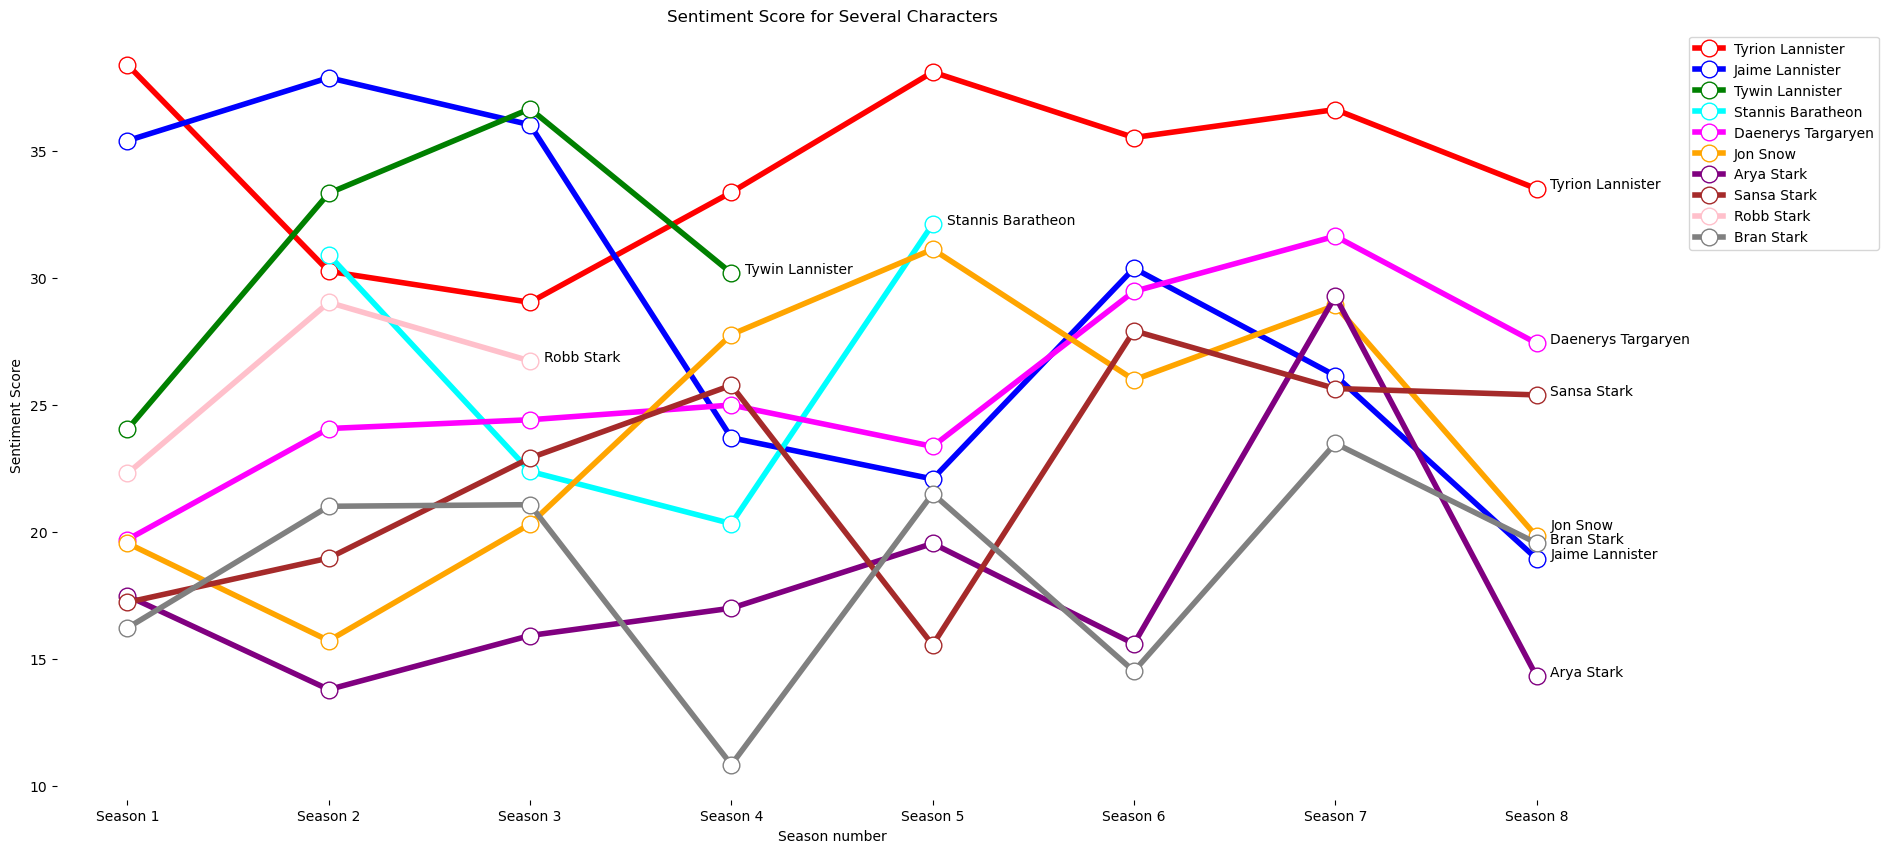

In [27]:
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (20,10)

for element in lists_of_char:
    # if element is either 0 or inf, set it to nan
    element['Rank'][element['Rank'] == 0] = np.nan
    ax.plot(seasons, element['Rank'], label=element['Name'], marker='o', markerfacecolor='white', markersize=12, color=element['Color'], linewidth=4)
    # Remove elements with sentiment score of 0
    xy = (7, element['Rank'][-1])
    # If element has a sentiment score of nan, set xy to the previous element that is not nan
    if np.isnan(xy[1]):
        for i in range(len(element['Rank'])-1, -1, -1):
            if not np.isnan(element['Rank'][i]):
                xy = (i, element['Rank'][i])
                break
    
    xytext = (10, 0)
    if element['Name'] == 'Jon Snow':
        xytext = (10, 5)

    ax.annotate(element['Name'], xy=xy, xytext=xytext, textcoords='offset points')

for spine in ax.spines.values():
    spine.set_visible(False)

plt.ylabel('Sentiment Score')
plt.xlabel('Season number')
plt.title('Sentiment Score for Several Characters')
plt.legend(loc = 'upper right' , bbox_to_anchor = (1.18, 1))
plt.show()